In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
import glob, os

import scipy.stats as st
import timeit
from sklearn.decomposition import PCA

# Regress viral severity on predictors

(severity) ~ (# of human targets) + (# of papers studying the virus) + (size of viral genomes) + more predictors.

In [2]:
# also rearranged so that all Homo sapiens is in the right column
virus_human = pd.read_csv("../Processed/virus_human.csv")

# don't need virus_virus, which is a dataframe of viral proteins interacting with each other

proteins = pd.read_csv("../Processed/enriched_GO_proteins.csv")

In [3]:
# check that all human proteins are in the second column
print(virus_human['Taxname B'].unique(), virus_human['Taxid B'].unique())

# human should not be in the first column
print('Homo sapiens' in virus_human['Taxname A'].values)
print(9606 in virus_human['Taxid A'].values)

['Homo sapiens'] [9606]
False
False


In [4]:
print(len(virus_human["Taxname A"].unique()), "viral species in the PPI dataset")

181 viral species in the PPI dataset


In [5]:
print(len(virus_human["Taxid A"].unique()), "viral taxa in the PPI dataset")

181 viral taxa in the PPI dataset


In [6]:
# save taxids to a text file to search with Taxonomizr in R (code below)
virus_human[["Taxid A"]].drop_duplicates().to_csv("viral_taxids.txt", index=False, sep="\t")

# Get taxonomic ranks using `Taxonomizr` in R

## Easiest way to collapse groups of viruses (i.e. different papillomaviruses will also have the same genus)

https://cran.r-project.org/web/packages/taxonomizr/vignettes/usage.html

```r
install.packages("taxonomizr")
library(taxonomizr)

prepareDatabase('accessionTaxa.sql')

df <- read.table("viral_taxids.txt", stringsAsFactors=FALSE, quote="", header=TRUE, sep="\t")

taxids <- df[["Taxid.A"]]

# get taxonomies for the taxids
taxa <- getTaxonomy(taxids,'accessionTaxa.sql')

# save taxa to a new dataframe
write.csv(taxa, "viral_taxonomies.csv")
```

In [7]:
# viral_taxonomies = pd.read_csv("viral_taxonomies.csv")
# viral_taxonomies.rename(columns={viral_taxonomies.columns[0]: 'Taxid A'}, inplace=True)

# # combine the taxonomies with the original dataframe
# virus_human = pd.merge(virus_human, viral_taxonomies, on='Taxid A')
# virus_human.to_csv("../Processed/virus_human.csv", index=False)

# Get genome sizes of all the viruses

https://www.ncbi.nlm.nih.gov/genome/browse/#!/viruses/

Use taxonomizr to get the exact species name, rather than the strain name (which is what's associated with the taxids).

This species name should be easier to search than the taxid-associated taxname.

In [8]:
virus_genome_sizes = pd.read_csv("../Data/virus_genome_sizes.csv")

In [9]:
# ~1/2 as many species as taxids
print(len(virus_human.species.unique()))

# make a dictionary to map between them
taxnames_species_dict = dict(zip(virus_human["Taxname A"], virus_human["species"]))

86


In [10]:
# this only has 62 of the 83 species in the dataframe. Compare families for the rest because the Organism Groups column contains them
found_viruses_df = virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].isin(virus_human['species'].unique())].drop_duplicates(["#Organism Name", "Size(Mb)"])

found_viruses = found_viruses_df["#Organism Name"].unique()

print(len(found_viruses), "viruses found in the database")

missing_viruses = list(set(virus_human['species'].unique()) - set(found_viruses))

print(len(missing_viruses), "viruses not a direct match")

62 viruses found in the database
24 viruses not a direct match


In [11]:
virus_genomes_df = pd.DataFrame(found_viruses_df.groupby("#Organism Name")["Size(Mb)"].mean()).reset_index()
virus_genomes_df.columns = ["Species", "Size(Mb)"]

add_viruses_to_df = []
genome_sizes = []

for virus in missing_viruses:
    
    res_df = virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].str.contains("|".join(virus.split(" ")), case=False)]
    if len(res_df) > 0:
        genome_sizes.append(res_df["Size(Mb)"].mean())
        add_viruses_to_df.append(virus)
    else:
        print(virus)
        
# add rubella virus manually because it's just 1 virus
add_viruses_to_df.append("Rubivirus rubellae")
genome_sizes.append(virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].str.contains("rubella", case=False)]["Size(Mb)"].mean())

virus_genomes_df = pd.concat([virus_genomes_df, pd.DataFrame({"Species": add_viruses_to_df, "Size(Mb)": genome_sizes})]).reset_index(drop=True)

assert len(set(virus_genomes_df["Species"]).intersection(virus_human["species"])) == len(virus_genomes_df)

Rubivirus rubellae


In [26]:
model_df = pd.DataFrame(taxnames_species_dict, index=[0]).T.reset_index()
model_df.columns = ["Taxname", "Species"]

# combine with the genome lengths
model_df = pd.merge(model_df, virus_genomes_df, on="Species", how="outer")

# number of proteins interacting with human proteins for a given viral species
protein_interactions = pd.DataFrame(virus_human.groupby(["Taxname A"])["Protein A"].apply(lambda x: len(np.unique(x)))).reset_index()
protein_interactions.columns = ["Taxname", "num_unique_interactions"]

# combine with the protein_interactions list
model_df = pd.merge(model_df, protein_interactions, on="Taxname", how="outer")

publications_df = pd.DataFrame(virus_human.groupby(["Taxname A"])["Publication"].apply(lambda x: len(np.unique(x)))).reset_index()
publications_df.columns = ["Taxname", "num_publications"]

# combine with the publications list
model_df = pd.merge(model_df, publications_df, on="Taxname", how="outer")

# add the taxids for easy cross-referencing
model_df = pd.merge(virus_human[["Taxid A", "Taxname A"]].drop_duplicates(), model_df, left_on="Taxname A", right_on="Taxname", how="inner")

# duplicate column now
del model_df["Taxname A"]

model_df.rename(columns={"Taxid A": "Taxid"}, inplace=True)

# finally, save it to a dataframe for modeling later (need the outcome variable)
model_df.to_csv("model_predictors.csv", index=False)

### Manually determined which viruses predominantly infect animals and removed them

In [80]:
nonhuman_viruses = ['Betacoronavirus England 1', 'Severe acute respiratory syndrome-related coronavirus', 
                   'Middle East respiratory syndrome-related coronavirus', 'Avian infectious bronchitis virus (strain Beaudette US)',
                   'Avian infectious bronchitis virus (strain Beaudette)', 'Avian sarcoma virus PR2257', 'Macaca mulatta polyomavirus 1',
                   "Marek's disease herpesvirus type 1 strain MD5", 'Pipistrellus bat coronavirus HKU5', 'Rousettus bat coronavirus HKU9',
                    'Canine enteric coronavirus INSAVC-1','Porcine transmissible gastroenteritis coronavirus strain Purdue',
                    'Porcine respiratory coronavirus (STRAIN RM4)', 'Bat SARS CoV Rp3/2004', 'Murine hepatitis virus strain A59', 
                    'Bovine coronavirus strain Quebec', 'Semliki Forest virus', 'Suid alphaherpesvirus 1', 
                    'Equine herpesvirus type 1 (strain Kentucky A)', 'Equid alphaherpesvirus 1', 'Equid herpesvirus type 2 strain 86/87',
                   'Bos taurus papillomavirus 2', 'Murine adenovirus 1', 'Fowl aviadenovirus 1', 'Hog cholera virus (strain Alfort)',
                   'Bovine herpesvirus type 1.1', 'Bovine gammaherpesvirus 4', 'Bovine herpesvirus type 1.1 (strain Cooper)',
                   'Bat coronavirus BM48-31/BGR/2008', 'Mus musculus polyomavirus 1', 'Rous sarcoma virus (strain Schmidt-Ruppin A)',
                   'Murid gammaherpesvirus 4', 'Bovine alphaherpesvirus 1','Bat coronavirus RaTG13', 'Pangolin coronavirus', 'Simian virus 5 (strain W3)',
                    'Bovine herpesvirus type 1.1 (strain Jura)', 'Classical swine fever virus - Alfort/187', 'Classical swine fever virus - Brescia',
                    'Bat SARS-like coronavirus WIV1', 'Encephalomyocarditis virus', 'SARS coronavirus HB','Porcine enteric alphacoronavirus','Murine cytomegalovirus (strain Smith)',
                   'Bovine viral diarrhea virus 1-NADL', 'African swine fever virus', 'Murine polyomavirus strain A3',
                   'Herpesvirus saimiri (strain 488)', 'Herpesvirus saimiri (strain 11)']

model_df_human = model_df.loc[~model_df["Taxname"].isin(nonhuman_viruses)]
model_df_human.to_csv("model_predictors_human.csv", index=False)

In [82]:
#list(model_df.Taxname)

In [83]:
model_df = pd.read_csv("model_predictors.csv")
model_df_human = pd.read_csv("model_predictors_human.csv")

In [84]:
def spearman_rho_corr(df, col1, col2):
    
    sns.scatterplot(data=df, x=col1, y=col2)
    plt.xscale("log")
    plt.yscale("log")
    sns.despine()
    plt.show()
    
    return st.spearmanr(df[col1], df[col2])

### Essentially the same correlation coefficient for all viruses and human-only viruses

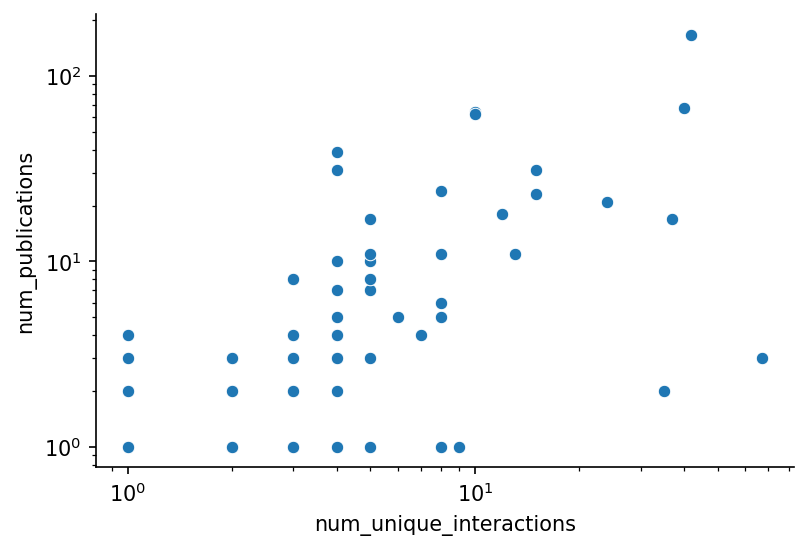

SpearmanrResult(correlation=0.8107071469106947, pvalue=1.7608737202462508e-43)

In [85]:
# might be the biggest predictor. Spearman rho totally not significant for num_interactions and genome size
spearman_rho_corr(model_df, "num_unique_interactions", "num_publications")

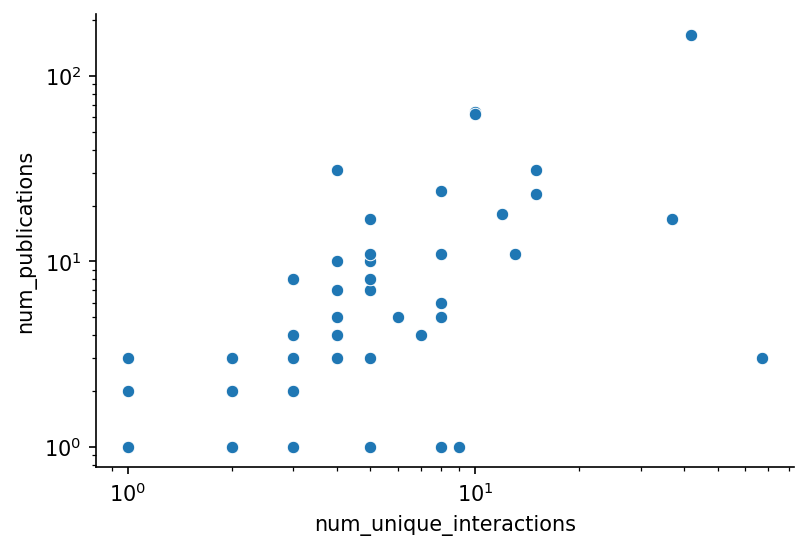

SpearmanrResult(correlation=0.8284208309448539, pvalue=1.5832067269914599e-34)

In [86]:
# might be the biggest predictor. Spearman rho totally not significant for num_interactions and genome size
spearman_rho_corr(model_df_human, "num_unique_interactions", "num_publications")

In [91]:
model_df_human

,Taxid,Taxname,Species,Size(Mb),num_unique_interactions,num_publications
0,11295,Rabies virus ERA,Rabies lyssavirus,0.011917,2,2
1,11137,Human coronavirus 229E,Human coronavirus 229E,0.027317,8,5
2,1235996,Human betacoronavirus 2c EMC/2012,Middle East respiratory syndrome-related coron...,0.030119,4,3
3,2697049,Severe acute respiratory syndrome coronavirus 2,Severe acute respiratory syndrome-related coro...,0.029274,42,166
4,211044,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Influenza A virus,0.044116,8,6
...,...,...,...,...,...,...
127,11250,Human orthopneumovirus,Human orthopneumovirus,0.015223,1,1
128,31547,human papillomavirus 20,Betapapillomavirus 1,0.007533,1,1
129,11108,Hepatitis C virus (isolate H),Hepacivirus C,0.009432,1,1
130,329389,Hepatitis C virus (isolate Glasgow),Hepacivirus C,0.009432,1,1


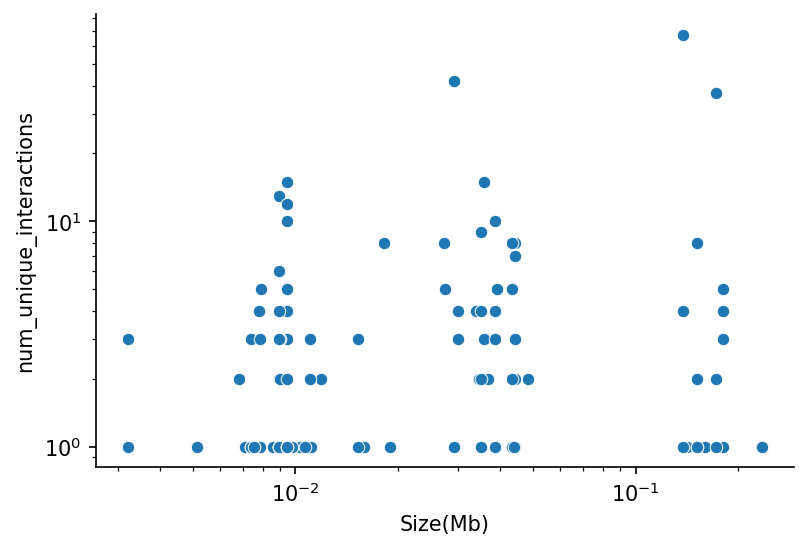

SpearmanrResult(correlation=0.10861439682818133, pvalue=0.2150913215661996)

In [93]:
# might be the biggest predictor. Spearman rho totally not significant for num_interactions and genome size
spearman_rho_corr(model_df_human, "Size(Mb)", "num_unique_interactions")

# Use fatality rate for viral severity? And # of infections worldwide?

# Curate tropism, respiratory vs. GI vs. immune vs. other, latent vs. nonlatent infection

# Could be more interesting predictor OR outcome variables!

predictor ~ severity + tropism + publications + 

In [112]:
human_tropisms = []

for virus in model_df_human.Species.values:
    
    if any(map(virus.lower().__contains__, ["influenza", "coronavirus", "respiratory", "henipavirus", "measles", "adeno",
                                           "orthopneumovirus", "vesiculo", "parvo"])):
        human_tropisms.append("respiratory")
        
    # betaherpesviruses include CMV
    elif any(map(virus.lower().__contains__, ["zika", "rabies", "betaherpesvirus"])):
        human_tropisms.append("neuronal")
        
    # Orthohepe is hepatitis E virus
    elif any(map(virus.lower().__contains__, ["hepa", "hepe"])):
        human_tropisms.append("liver")
        
    elif any(map(virus.lower().__contains__, ["hiv", "immunodeficiency", "lymphotropic", "gammaherpesvirus 4", "lymphocytic",
                                             "dengue"])):
        human_tropisms.append("immune")
        
    # gammaherpes 8 = KSHV, alphaherpesviruses are HSV-1 and HSV-2. They infect neuronal cells too, but predominantly epithelial
    # simplification for this problem
    elif any(map(virus.lower().__contains__, ["papilloma", "polyoma", "gammaherpesvirus 8", "alphaherpesvirus", "pox", "vaccinia",
                                             "ebola", "bandavirus"])):
        human_tropisms.append("epithelial")
        
    # hand foot and mouth disease
    elif virus == "Enterovirus A":
        human_tropisms.append("epitherlial")
        
    # poliovirus
    elif virus == "Enterovirus C":
        human_tropisms.append("neuronal")
        
    else:
        print(virus)

Kyasanur Forest disease virus
West Nile virus
Tick-borne encephalitis virus
Japanese encephalitis virus
West Nile virus
Rubivirus rubellae
Phlebovirus WCH/97/HN/China/2011


In [113]:
len(human_tropisms), len(model_df_human.Species)

(125, 132)

In [117]:
len(pd.read_csv("../Processed/virus_human.csv"))

24016

# Cancer implications?

## Look through the GO functions and identify those implicated in cancer

i.e. miRNA, telomere / telomerase, DNA repair

### Look at which viruses are enriched for interactions with those human proteins. 

Hopefully would see like HIV, hepatitis viruses, HPV, certain herpes viruses, etc.

In [ ]:
[1, 0, 0.33, 0.01, 0.02, 0.1, 0, 0, 0, 0.5, 0.7, 0.1, 0.02, 0.02, ]

In [114]:
list(model_df_human.Taxname)

['Rabies virus ERA',
 'Human coronavirus 229E',
 'Human betacoronavirus 2c EMC/2012',
 'Severe acute respiratory syndrome coronavirus 2',
 'Influenza A virus (A/Puerto Rico/8/1934(H1N1))',
 'Zika virus',
 'Enterovirus A71',
 'Human coronavirus OC43',
 'Human coronavirus NL63',
 'Influenza A virus (A/Viet Nam/1203/2004(H5N1))',
 'Nipah henipavirus',
 'SARS coronavirus GZ02',
 'Influenza A virus (A/California/04/2009(H1N1))',
 'Influenza A virus (A/Wilson-Smith/1933(H1N1))',
 'Human papillomavirus type 18',
 'Human adenovirus 5',
 'Human gammaherpesvirus 8',
 'Hepatitis C virus (isolate Japanese)',
 'Human alphaherpesvirus 1 strain 17',
 'Human herpesvirus 4 strain B95-8',
 'Human immunodeficiency virus type 1 (CLONE 12)',
 'Human immunodeficiency virus 1',
 'Hepacivirus C',
 'Human adenovirus 12',
 'Human adenovirus 2',
 'Human betaherpesvirus 5',
 'Human alphaherpesvirus 1',
 'Human herpesvirus 2 strain HG52',
 'HIV-1 M:B_HXB2R',
 'Human immunodeficiency virus type 1 (BRU ISOLATE)',
 '

In [87]:
list(model_df_human.Species)

['Rabies lyssavirus',
 'Human coronavirus 229E',
 'Middle East respiratory syndrome-related coronavirus',
 'Severe acute respiratory syndrome-related coronavirus',
 'Influenza A virus',
 'Zika virus',
 'Enterovirus A',
 'Betacoronavirus 1',
 'Human coronavirus NL63',
 'Influenza A virus',
 'Nipah henipavirus',
 'Severe acute respiratory syndrome-related coronavirus',
 'Influenza A virus',
 'Influenza A virus',
 'Alphapapillomavirus 7',
 'Human mastadenovirus C',
 'Human gammaherpesvirus 8',
 'Hepacivirus C',
 'Human alphaherpesvirus 1',
 'Human gammaherpesvirus 4',
 'Human immunodeficiency virus 1',
 'Human immunodeficiency virus 1',
 'Hepacivirus C',
 'Human mastadenovirus A',
 'Human mastadenovirus C',
 'Human betaherpesvirus 5',
 'Human alphaherpesvirus 1',
 'Human alphaherpesvirus 2',
 'Human immunodeficiency virus 1',
 'Human immunodeficiency virus 1',
 'Human immunodeficiency virus 1',
 'Betapapillomavirus 1',
 'Human gammaherpesvirus 4',
 'Primate T-lymphotropic virus 1',
 'Alph

In [ ]:
model_df_human.Taxname

In [52]:
list(model_df_human.Taxname)

['Rabies virus ERA',
 'Human coronavirus 229E',
 'Human betacoronavirus 2c EMC/2012',
 'Severe acute respiratory syndrome coronavirus 2',
 'Influenza A virus (A/Puerto Rico/8/1934(H1N1))',
 'Zika virus',
 'Enterovirus A71',
 'Human coronavirus OC43',
 'Human coronavirus NL63',
 'Influenza A virus (A/Viet Nam/1203/2004(H5N1))',
 'Nipah henipavirus',
 'SARS coronavirus GZ02',
 'Influenza A virus (A/California/04/2009(H1N1))',
 'Influenza A virus (A/Wilson-Smith/1933(H1N1))',
 'Herpesvirus saimiri (strain 488)',
 'Human papillomavirus type 18',
 'Human adenovirus 5',
 'Human gammaherpesvirus 8',
 'Hepatitis C virus (isolate Japanese)',
 'Human alphaherpesvirus 1 strain 17',
 'Human herpesvirus 4 strain B95-8',
 'Human immunodeficiency virus type 1 (CLONE 12)',
 'Human immunodeficiency virus 1',
 'Hepacivirus C',
 'Human adenovirus 12',
 'Human adenovirus 2',
 'Human betaherpesvirus 5',
 'Human alphaherpesvirus 1',
 'Human herpesvirus 2 strain HG52',
 'HIV-1 M:B_HXB2R',
 'Human immunodefic

<b>Maybe see where they're located in PFAM domain space (no dimensionality reduction, just compute Euclidean distance in however many dimensions there are).</b>

<b>Could build a phylogenetic tree and pick viruses that share a common ancestor within some distance. Then use sequences of the homologous proteins as inputs to a model.</b>

In [48]:
# how many human proteins does each virus interact with? 
human_proteins_per_virus = pd.DataFrame(virus_human.groupby(["Taxname A", "Protein B"])["Protein A"].apply(lambda x: len(np.unique(x)))).reset_index()
human_proteins_per_virus.columns = ["viral_species", "human_uniprot", "counts"]

# normalize to the mean
#human_proteins_per_virus["norm_counts"] = (human_proteins_per_virus.counts - human_proteins_per_virus.counts.mean())
#human_proteins_per_virus["norm_counts"] = np.log(human_proteins_per_virus["counts"])

# convert to matrix
data = human_proteins_per_virus.pivot(index="viral_species", columns="human_uniprot", values="counts").fillna(0)

In [39]:
np.min(human_proteins_per_virus.norm_counts), np.max(human_proteins_per_virus.norm_counts)

(-0.15445280271778694, 13.845547197282214)

/Users/skulkarni/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1800x1800 with 0 Axes>

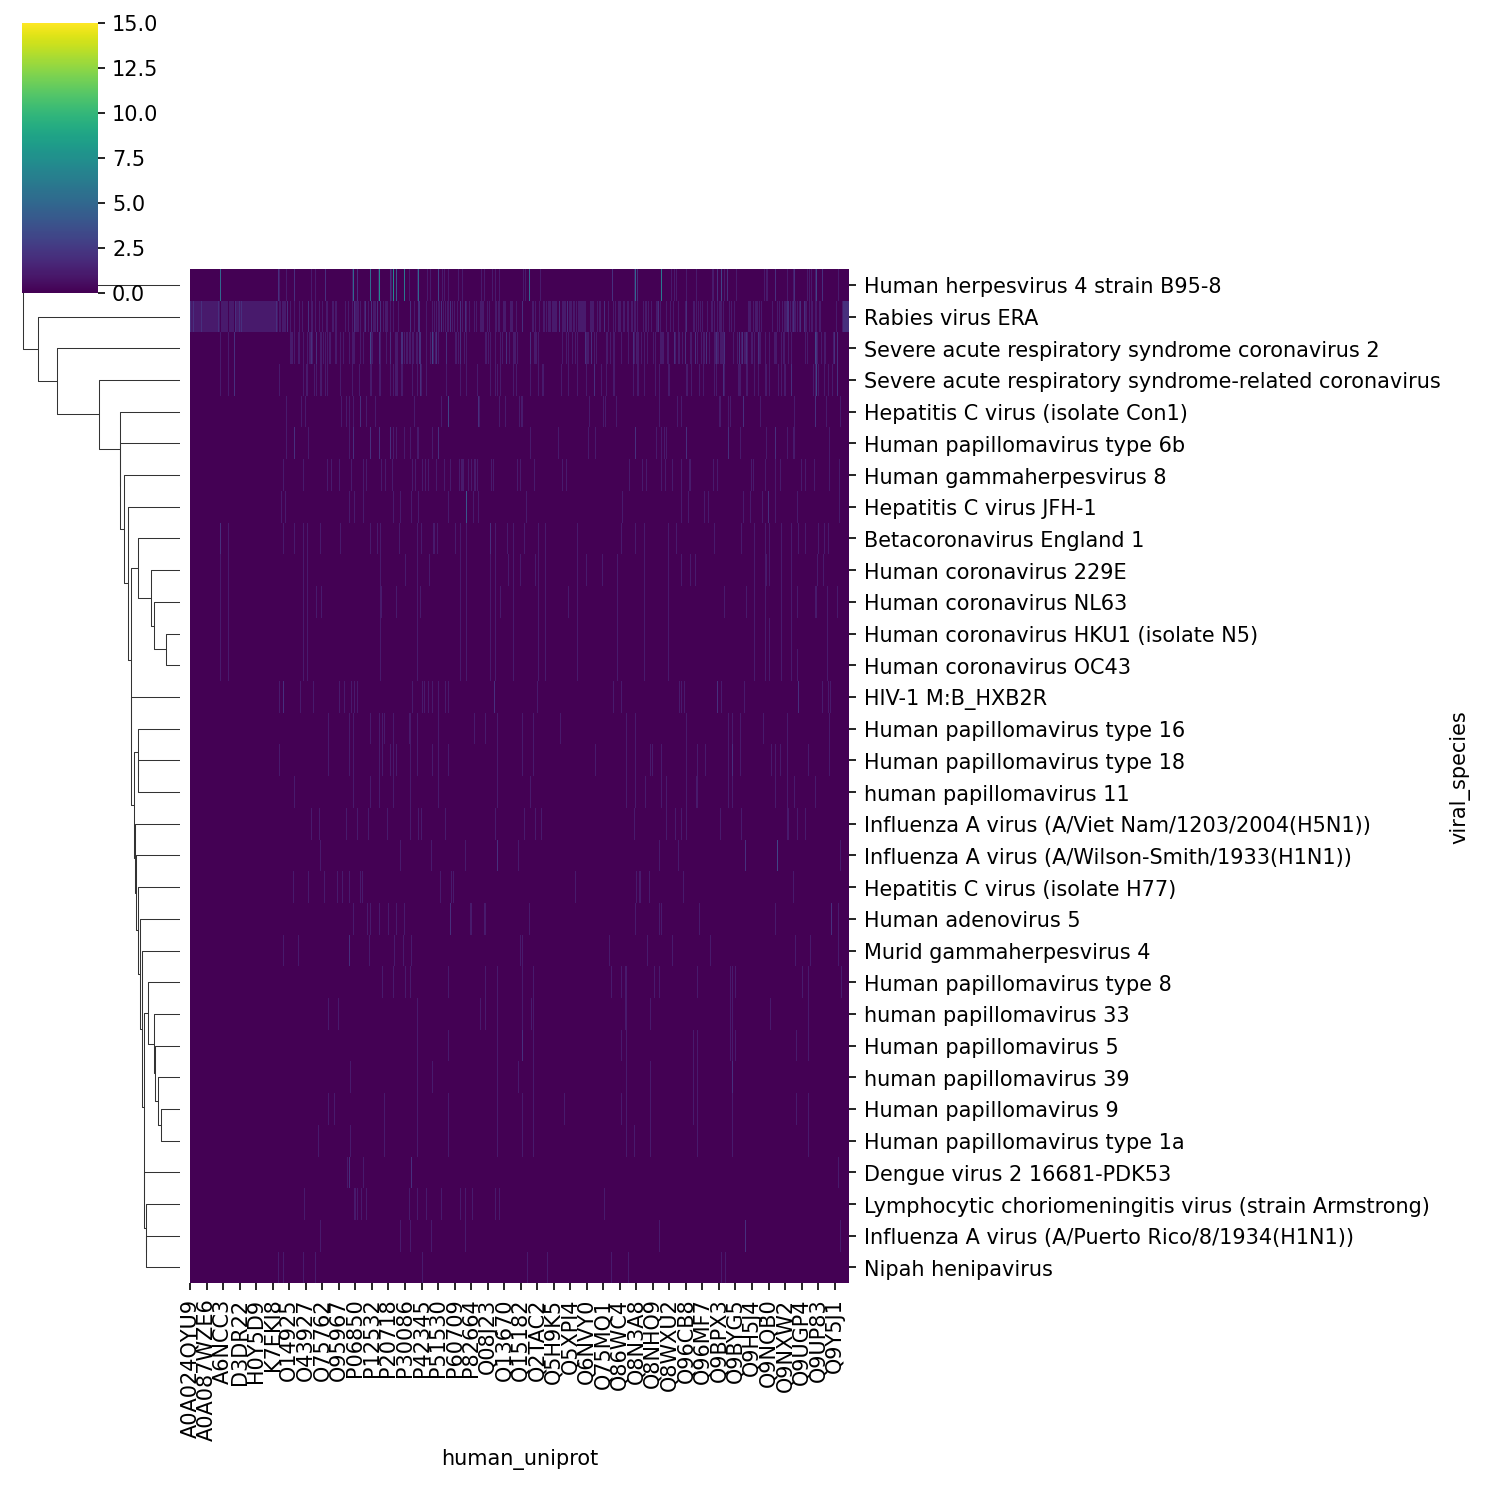

In [54]:
plt.figure(figsize=(12, 12))
sns.clustermap(data.loc[data.index[(data.sum(axis=1) > 100).values], :], col_cluster=False, cmap="viridis")
plt.show()

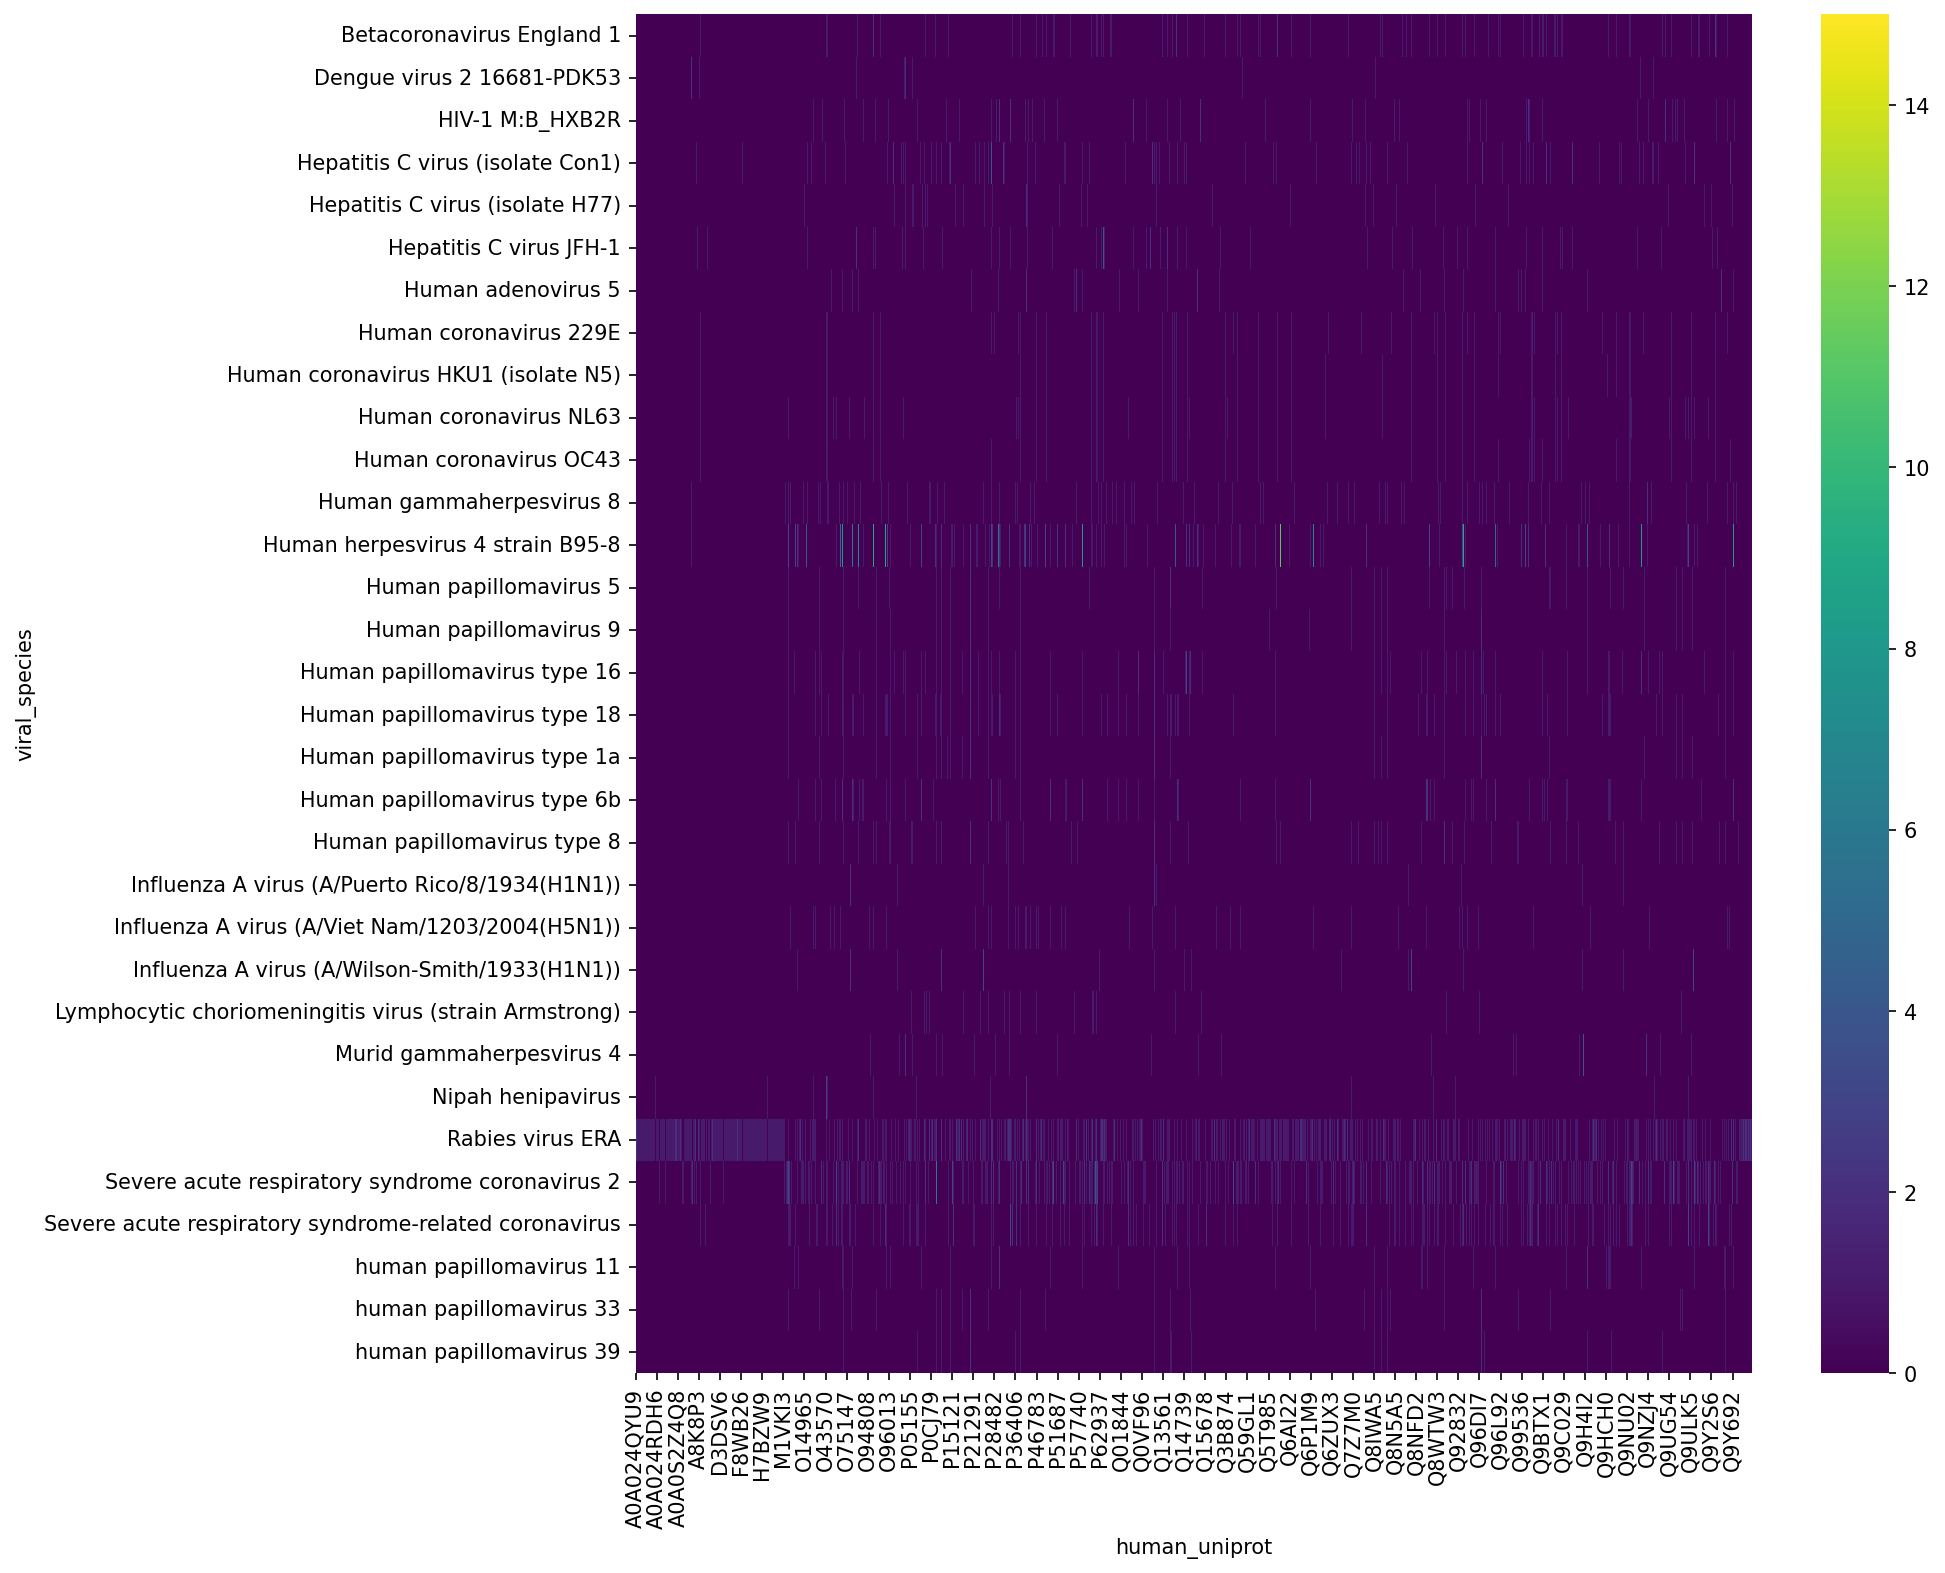

In [24]:
plt.figure(figsize=(12, 12))
sns.heatmap(data.loc[data.index[(data.sum(axis=1) > 100).values], :], cmap="viridis")
plt.show()

### Epstein-Barr virus has the most documented interactions with human proteins

### Maybe point out that it's surprising that Nipah made it to the list, given that it's so rare

That one paper found ~60-70 interactions

In [299]:
pca = PCA(10).fit(data)

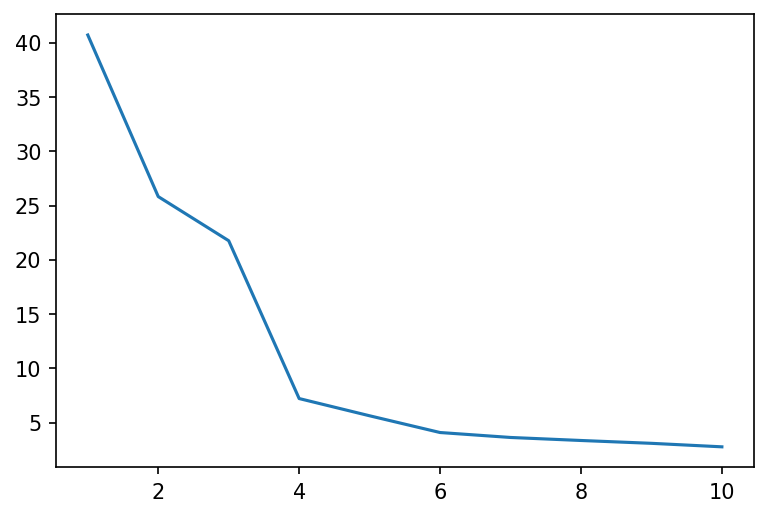

In [ ]:
plt.plot(np.arange(1, 11), pca.explained_variance_)

In [305]:
pca_2 = PCA(6)
pca_2.fit(data.values)

pca_transformed = pca_2.transform(data.values)

In [308]:
pc1, pc2, _, _, _, _ = list(zip(*pca_transformed))

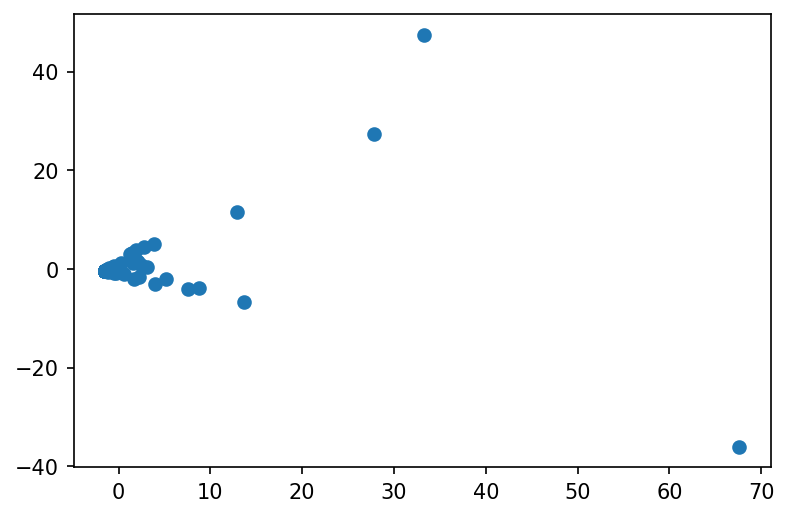

In [309]:
plt.scatter(pc1, pc2)